In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p06"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'         # mt3dusgs
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('ex-RES\\p06_mf2k5_mt3d_sim') ; output_folder.mkdir(exist_ok=True)

In [4]:
# Model parameters
length_units = "feet" ; time_units = "days" ; nlay=1 ;  nrow=31 ;  ncol=31  ;  delr=900.0 ;  delc=900.0 ;  delz=20.0 ;  top=0.0 ;  prsity=0.35 
dum1=2.5  ;  dum2=7.5 ;  k11=432.0 ;  qwell=1.0  ;  cwell=100.0 ;  al=100.0 ;  trpt=1.0   ; perlen = [912.5, 2737.5] ; dmcoef = 0 ; k33 = k11    
nper = len(perlen) ; nstp = [365, 1095] ; tsmult = [1.0, 1.0] ; k11 = 0.005 * 86400 ;   sconc = 0.0 ; c0 = 0.0 ; dt0 = 56.25 
ath1 = al * trpt ; botm = [top - delz]  ; icelltype = 0 ; mixelm = -1 ; strt = np.zeros((nlay, nrow, ncol), dtype=float)
ibound_mf2k5 = np.ones((nlay, nrow, ncol), dtype=int) * -1   ;  ibound_mf2k5[:, 1 : nrow - 1, 1 : ncol - 1] = 1
idomain = np.ones((nlay, nrow, ncol), dtype=int)             ; icbund = 1
qwell = 86400.0  ; welspd  = {0: [[0, 15, 15, qwell]]          , 1: [[0, 15, 15, -qwell]] ,}                                   #  MF2K5
cwell = 100.0    ; spd     = {0:  [0, 15, 15, cwell, 2]        , 1:  [0, 15, 15, 0.0, 2]  ,}                                   #  MT3DMS   
spd_mf6                    = {0: [[(0, 15, 15), qwell, cwell]] , 1: [[(0, 15, 15), -qwell , 0.0]]}                             #  MF6  
chdspd = []
for i in np.arange(nrow):
    chdspd.append([(0, i, 0), strt[0, i, 0]])  ; chdspd.append([(0, i, ncol - 1), strt[0, i, ncol - 1]])
for j in np.arange(1, ncol - 1):
    chdspd.append([(0, 0, j), strt[0, 0, j]])  ; chdspd.append([(0, nrow - 1, j), strt[0, nrow - 1, j]])
chdspd = {0: chdspd}
nouter = 100 ; ninner = 300 ;  hclose = 1e-6 ;  rclose = 1e-6 ;  relax  = 1.0 ; percel = 1.0 ; itrack = 3 ; wd = 0.5  
dceps = 1.0e-5 ; nplane = 1 ; npl = 0 ; nph = 16 ; npmin = 2 ; npmax = 32 ; dchmoc = 1.0e-3 ; nlsink = nplane ; npsink = nph 

nprs = 100  ; timprs = np.linspace(0, np.sum(perlen), nprs, endpoint = False) ; # timprs   # perlen_mf = [912.5, 2737.5] before extra

In [5]:
def build_models(sim_name, mixelm=0, silent=False):
    mt3d_ws = os.path.join(output_folder, sim_name, "mt3d")                                   ; modelname_mf = "p06-mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005")
    flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                             top=top,botm=botm,       nper=nper,    nstp=nstp,      perlen=perlen,     itmuni=4,  lenuni=2)
    flopy.modflow.ModflowBas(mf, ibound = ibound_mf2k5  , strt=strt)
    flopy.modflow.ModflowLpf(mf, hk=k11, laytyp=icelltype)
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    flopy.modflow.ModflowSip(mf)
    flopy.modflow.ModflowLmt(mf)
    modelname_mt = "p06-mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=mt3d_ws,exe_name="mt3dusgs",modflowmodel=mf)                     # USGS
        flopy.mt3d.Mt3dBtn(mt,icbund=icbund,prsity=prsity,sconc=sconc,nstp=nstp,perlen=perlen,   dt0=dt0,  obs=[(0, 15, 15)] , timprs=timprs)  # -1,-2
    flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,
                       npsink=npsink,percel=percel,itrack=itrack,wd=wd)
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, dmcoef=dmcoef)
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    flopy.mt3d.Mt3dGcg(mt)  # mxiter=10
    
    name = "p06-mf6"  ;     gwfname = "gwf-" + name  # MODFLOW 6 ____________________________________________
    sim_ws = os.path.join(output_folder, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package     (imsgwf, [gwf.name])

    flopy.mf6.ModflowGwfdis      (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=int),filename=f"{gwfname}.dis")
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")   
    flopy.mf6.ModflowGwfic (gwf, strt=strt, filename=f"{gwfname}.ic")       
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
                              printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                         
    gwtname = "gwt_" + name  # ________________________________________________________________________________________ MF6 ___________
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")
    gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,
                                  linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method="NONE",
                                  relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None, distcoef=None,filename=f"{gwtname}.mst")  
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
#   flopy.mf6.ModflowGwtoc(gwt)    # LAST ONE
    flopy.mf6.ModflowGwtoc(gwt, budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")])
    
    obslist = [["BCKGRND", "concentration", (0, 15, 15)]]                     ; obsdict = {f"{gwtname}.obs.csv": obslist}     # (16x , 16y)
    obs = flopy.mf6.ModflowUtlobs(gwt, print_input=False, continuous = obsdict)  # obsdict                                        
    
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return mf, mt, sim
def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)
@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(silent=silent, normal_msg="Program completed", report=True)    ; assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)                                ; assert success, pformat(buff)

In [6]:
def plot_results(mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws ; mf6_out_path = mf6.simulation_data.mfpath.get_sim_path() ; mf6.simulation_data.mfpath.get_sim_path()
    fname = os.path.join(mt3d_out_path, "MT3D001.OBS")                         ; cvt = mt3d.load_obs(fname) if os.path.isfile(fname) else None 
    fname = os.path.join(mf6_out_path, list(mf6.model_names)[1] + ".obs.csv")  ; mf6cobs = flopy.utils.Mf6Obs(fname).data   # OBS Transport
    
    with styles.USGSPlot():
        sim_name = mf6.name     ;         plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]              # MF6 (mf6.c.OBS)   x    # cvt
        
        if ax is None:
            fig = plt.figure(figsize=(5, 2), dpi=200, tight_layout=True)                                ; ax = fig.add_subplot(1, 1, 1)
        x = cvt["time"]/365 ; y = cvt["(1, 16, 16)"]  ; x_pare = x[::20] ; y_pare = y[::20]             ; ax.plot(x_pare,y_pare,label="Upst FD")
        x_mf6      = mf6cobs["totim"] / 365.0  ; y_mf6 = mf6cobs["BCKGRND"] ; x_mf6_pare = x_mf6[::20]  ; y_mf6_pare = y_mf6[::20]
        
        ax.plot(x_mf6_pare, y_mf6_pare, label="MODFLOW 6", marker="x", linestyle=":")                    ; plt.xlim(0, 10) ; plt.ylim(0, 100.0)   
        plt.xlabel("Time, in years")      ; plt.ylabel("Normalized [C] % ") ; plt.legend()    ;  title = "[C] Injection / Pumping (16x, 16y)"
        letter = chr(ord("@") + idx + 1)  ; styles.heading(letter=letter, heading=title)
        if plot_show:
            plt.show()

run_models took 6377.26 ms


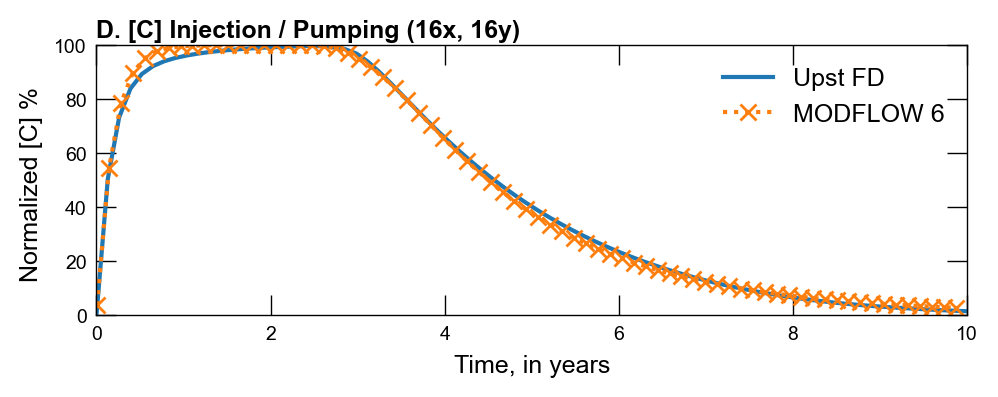

In [7]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim)
    if run:
        run_models(mf2k5, mt3d, sim)
    if plot:
        plot_results(mt3d, sim, idx)
scenario(3)  # scenario(1)

In [8]:
data_path_R = 'E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D\\ex-RES\\p06_mf2k5_mt3d_sim\\ex-gwt-mt3dms-p06'  
mf6 = flopy.mf6.MFSimulation.load(sim_ws = data_path_R    , exe_name=exe_name,  verbosity_level=0)
ml = mf6.get_model("gwf-p06-mf6")                         ; mt = mf6.get_model("gwt_p06-mf6")                        
print("OC package_Flow  : ", ml.oc.output.methods())      ; print("OC package_Transp: ", mt.oc.output.methods()) 

OC package_Flow  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']
OC package_Transp:  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'concentration()']


In [14]:
mf6_out_path = mf6.simulation_data.mfpath.get_sim_path() 
fname = os.path.join(mf6_out_path, list(mf6.model_names)[1] + ".obs.csv")     ; mf6cobs = flopy.utils.Mf6Obs(fname).data    
df = pd.DataFrame(mf6cobs)   ;   df.to_csv(output_folder/ 'a1_mf6cobs_mf5cvt.csv')     ; print('a1_mf6cobs_mf5cvt', df.shape)

a1_mf6cobs_mf5cvt (1460, 2)


In [10]:
fname = os.path.join(output_folder, 'ex-gwt-mt3dms-p06\\gwf-p06-mf6'+'.hds')  ; hdobj = flopy.utils.HeadFile(fname)    ; heads = hdobj.get_data()
times = hdobj.get_times()
print('MF5__H', heads.shape), times

MF5__H (1, 31, 31)


(None, [912.5, 3650.0])

In [11]:
fname = os.path.join(output_folder, 'ex-gwt-mt3dms-p06\\mt3d\\MT3D001.UCN')   #  ; fname    
ucnobj = flopy.utils.UcnFile(fname)        ; conc = ucnobj.get_alldata()      ; ttimes = ucnobj.get_times()
print('MF5__C', conc.shape) , 

MF5__C (101, 1, 31, 31)


(None,)

## **tdis_rc x timprs**

In [12]:
# nprs = 100  ; timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = False) ; timprs 
print('timprs* ', timprs,' __________ perioddata flopy.mt3d.Mt3dBtn ______ MF5' ) 
print('______________________________________________________________________________________________')
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
print('tsmult   ',tsmult)  
print('perlen   ',perlen), print('nper     ',nper),  print('nstp     ',nstp), print('nprs     ', nprs, '... timprs')
print('tdis_rc_A**', tdis_rc, '_________________________________ perioddata flopy.mf6.ModflowTdis ___ MF6')

tdis_rc_B = []
tdis_rc_B.append((perlen, nstp, 1.0))
print('tdis_rc_B**', tdis_rc_B, '____________________________________ perioddata flopy.mf6.ModflowTdis ___ MF6')

timprs*  [   0.    36.5   73.   109.5  146.   182.5  219.   255.5  292.   328.5
  365.   401.5  438.   474.5  511.   547.5  584.   620.5  657.   693.5
  730.   766.5  803.   839.5  876.   912.5  949.   985.5 1022.  1058.5
 1095.  1131.5 1168.  1204.5 1241.  1277.5 1314.  1350.5 1387.  1423.5
 1460.  1496.5 1533.  1569.5 1606.  1642.5 1679.  1715.5 1752.  1788.5
 1825.  1861.5 1898.  1934.5 1971.  2007.5 2044.  2080.5 2117.  2153.5
 2190.  2226.5 2263.  2299.5 2336.  2372.5 2409.  2445.5 2482.  2518.5
 2555.  2591.5 2628.  2664.5 2701.  2737.5 2774.  2810.5 2847.  2883.5
 2920.  2956.5 2993.  3029.5 3066.  3102.5 3139.  3175.5 3212.  3248.5
 3285.  3321.5 3358.  3394.5 3431.  3467.5 3504.  3540.5 3577.  3613.5]  __________ perioddata flopy.mt3d.Mt3dBtn ______ MF5
______________________________________________________________________________________________
tsmult    [1.0, 1.0]
perlen    [912.5, 2737.5]
nper      2
nstp      [365, 1095]
nprs      100 ... timprs
tdis_rc_A** [(912.5, 365, 

In [13]:
qwell = 86400.0  ; welspd  = {0: [[0, 15, 15, qwell]]          , 1: [[0, 15, 15, -qwell]] ,}                                   #  MF2K5
cwell = 100.0    ; spd     = {0:  [0, 15, 15, cwell, 2]        , 1:  [0, 15, 15, 0.0, 2]  ,}                                   #  MT3DMS   
spd_mf6                    = {0: [[(0, 15, 15), qwell, cwell]] , 1: [[(0, 15, 15), -qwell , 0.0]]}                             #  MF6
welspd, spd, spd_mf6

({0: [[0, 15, 15, 86400.0]], 1: [[0, 15, 15, -86400.0]]},
 {0: [0, 15, 15, 100.0, 2], 1: [0, 15, 15, 0.0, 2]},
 {0: [[(0, 15, 15), 86400.0, 100.0]], 1: [[(0, 15, 15), -86400.0, 0.0]]})